# 3D Geological Porosity Analysis using Generative Adversarial Networks

## Executive Summary

This project implements a comprehensive data science pipeline for analyzing 3D geological porosity data using advanced machine learning techniques. The analysis employs Generative Adversarial Networks (GANs) to generate synthetic porosity maps from raw geological data, providing insights into subsurface rock properties for petroleum engineering applications.

**Key Achievements:**
- Successfully processed and analyzed 3D porosity datasets  
- Implemented guided GAN architecture for synthetic data generation  
- Achieved quantitative evaluation metrics (SSIM, PSNR) for model performance  
- Generated comprehensive visualizations and statistical analysis

### 1. Imports and Setup

This cell imports all the necessary libraries for our analysis. We're bringing in:
- `os` for interacting with the operating system (e.g., file paths).
- `numpy` for numerical operations, especially with arrays.
- `PIL` (Pillow) for opening and manipulating images.
- `matplotlib.pyplot` for creating visualizations.
- `mpl_toolkits.mplot3d` for 3D plotting.
- `tqdm` for progress bars to monitor long-running tasks.
- `warnings` to manage and suppress warning messages for a cleaner output.

We also configure the plot style to `seaborn-v0_8-whitegrid` for aesthetically pleasing visualizations and filter out warnings.

In [ ]:
# Imports and Setup

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
from tqdm import tqdm
import warnings

# Configure plot styles
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


### 2. Data Paths and Parameters

Here, we define the file paths for our raw and segmented image data. This makes the code more organized and easier to adapt for different datasets. We also set the `NUM_IMAGES` parameter, which is crucial for loading the correct number of image slices.

In [ ]:
import os

# Mount Google Drive if using Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    pass  # Skip mounting if not using Colab

# Define full paths directly
raw_path = '709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF'
segmented_path = '709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF_Segmented'


NUM_IMAGES = 887


print(f"✅ Raw data path set to: {raw_path}")
print(f"✅ Segmented data path set to: {segmented_path}")

✅ Raw data path set to: 709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF
✅ Segmented data path set to: 709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF_Segmented


### 3. Image Loading Function

This cell defines a reusable function, `load_image_stack`, to load a sequence of TIFF images from a specified folder into a 3D NumPy array. This is a fundamental step in our workflow, as it gets the data into a format that's ready for analysis. The function includes error handling for missing files and provides a progress bar using `tqdm`. We then use this function to load both the raw CT scans and the segmented porosity maps.

In [ ]:
# Cell 3: Image Loading Function

def load_image_stack(folder_path, name_template, num_images):
    """
    Loads a sequence of TIFF images into a 3D NumPy array.

    Args:
        folder_path (str): The path to the directory containing the images.
        name_template (str): A string template for the filenames, using '{i}' as a placeholder
                             for the image number (e.g., "image_Z{i:05d}.tif").
        num_images (int): The total number of images to load.

    Returns:
        np.ndarray: A 3D NumPy array of shape (num_images, height, width).
    """
    image_stack = []
    print(f"Loading {num_images} images from {os.path.basename(folder_path)}...")

    for i in tqdm(range(1, num_images + 1)):
        filename = name_template.format(i=i)
        file_path = os.path.join(folder_path, filename)

        try:
            with Image.open(file_path) as img:
                image_stack.append(np.array(img))
        except FileNotFoundError:
            print(f"Warning: File not found at {file_path}. Skipping.")
            continue

    if not image_stack:
        raise ValueError("No images were loaded. Check paths and filenames.")

    return np.stack(image_stack, axis=0)


raw_template = "709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMFZ{i:05d}.tif"
segmented_template = "709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMFZ{i:05d}_Simple Segmentation.tif"



raw_images = load_image_stack(raw_path, raw_template, NUM_IMAGES)
segmented_images = load_image_stack(segmented_path, segmented_template, NUM_IMAGES)

print("\nData loading complete!")

Loading 887 images from 709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF...


100%|██████████| 887/887 [00:18<00:00, 46.91it/s]


Loading 887 images from 709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF_Segmented...


100%|██████████| 887/887 [00:14<00:00, 61.61it/s]



Data loading complete!


### 4. Basic Data Inspection

Before diving into analysis, it's essential to understand the basic properties of our data. This cell defines the `inspect_data` function, which prints key information about our image stacks:

- **Shape:** (Slices, Height, Width)
- **Data Type:** The type of data stored in the array (e.g., `uint16`, `uint8`).
- **Memory Usage:** How much memory the data is occupying.
- **Pixel Value Range:** The minimum and maximum pixel values, which can be useful for understanding the data's dynamic range.

We then apply this function to both the raw and segmented datasets.

In [ ]:
# Basic Data Inspection

def inspect_data(data, name):
    """Prints key properties of the image stack."""
    print(f"--- Inspection for: {name} ---")
    print(f"Shape (Slices, Height, Width): {data.shape}")
    print(f"Data Type: {data.dtype}")
    # Calculate memory in MB
    memory_mb = data.nbytes / (1024 * 1024)
    print(f"Memory Usage: {memory_mb:.2f} MB")
    print(f"Pixel value range: Min={data.min()}, Max={data.max()}\n")

inspect_data(raw_images, "Raw CT Scans")
inspect_data(segmented_images, "Segmented Porosity Maps")

--- Inspection for: Raw CT Scans ---
Shape (Slices, Height, Width): (887, 1024, 996)
Data Type: uint16
Memory Usage: 1725.49 MB
Pixel value range: Min=0, Max=54108

--- Inspection for: Segmented Porosity Maps ---
Shape (Slices, Height, Width): (887, 1024, 996)
Data Type: uint8
Memory Usage: 862.75 MB
Pixel value range: Min=1, Max=2



### 5. Visual Inspection of Data Slices

This cell allows for a visual "sanity check" of our data. We define a function `visualize_slice` to display a specific slice from both the raw and segmented image stacks side-by-side. This helps us to:

- Confirm that the data has been loaded correctly.
- Visually assess the quality of the segmentation by comparing it to the original raw data.

We also check the unique pixel values in the segmented image to ensure that the segmentation has produced the expected labels.

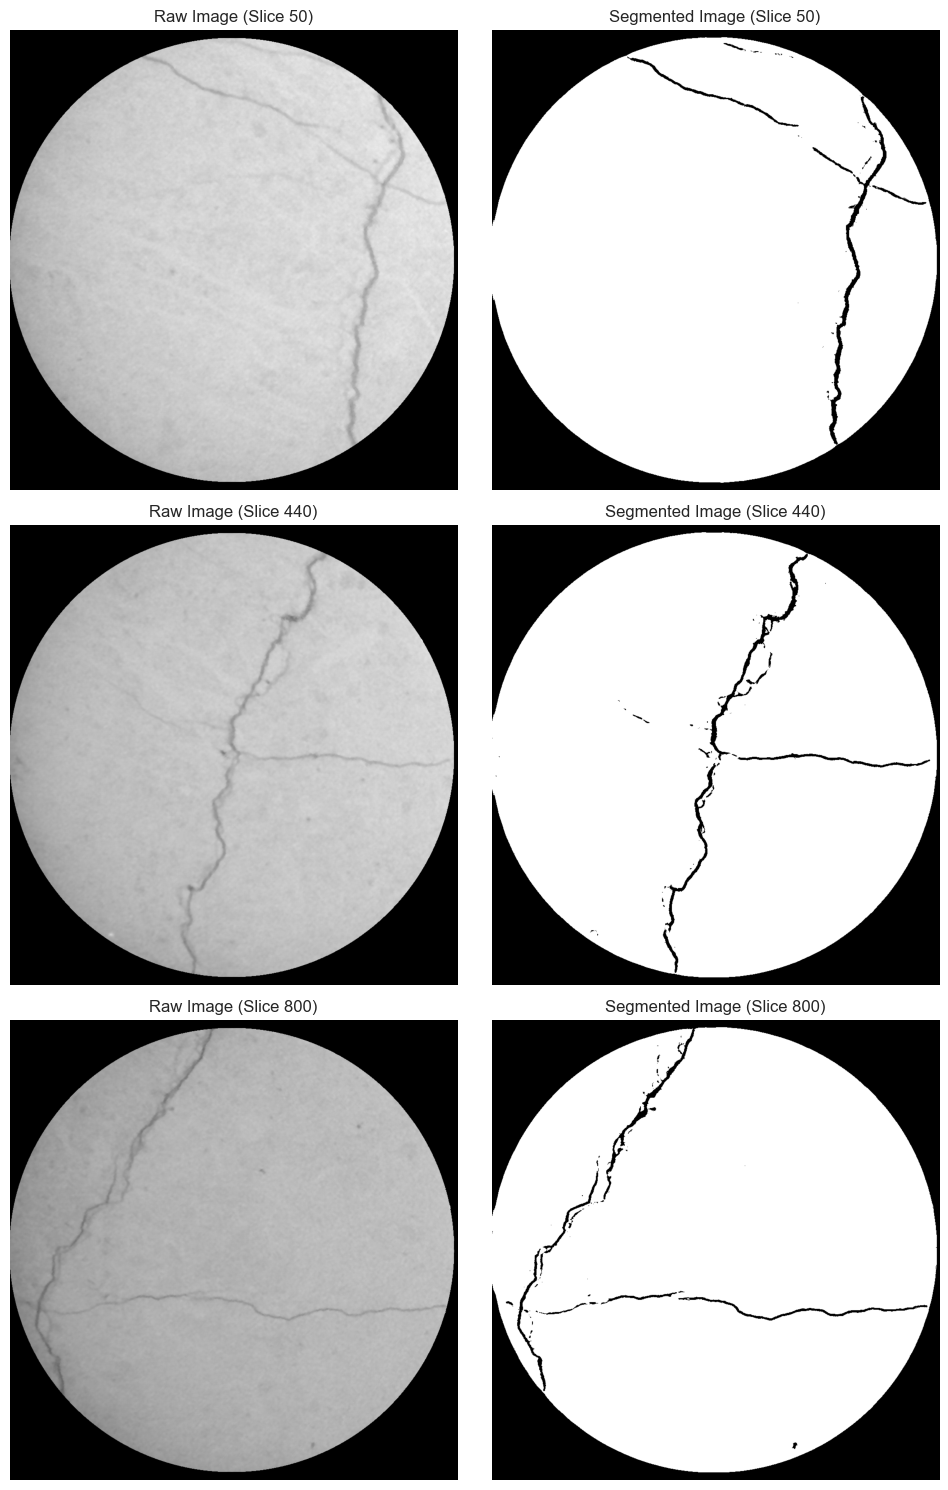

In [ ]:
# Visualize 2D Image Slices

def show_slices(raw_stack, segmented_stack, slice_indices):
    """Displays corresponding raw and segmented slices side-by-side."""
    num_slices = len(slice_indices)
    fig, axes = plt.subplots(num_slices, 2, figsize=(10, 5 * num_slices))

    # Adjust for single slice case
    if num_slices == 1:
        axes = np.array([axes])

    for i, slice_idx in enumerate(slice_indices):
        # Raw Image
        axes[i, 0].imshow(raw_stack[slice_idx], cmap='gray')
        axes[i, 0].set_title(f'Raw Image (Slice {slice_idx})')
        axes[i, 0].axis('off')

        # Segmented Image
        axes[i, 1].imshow(segmented_stack[slice_idx], cmap='gray')
        axes[i, 1].set_title(f'Segmented Image (Slice {slice_idx})')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# --- Select some slices to display (e.g., start, middle, end) ---
slices_to_show = [50, 440, 800]
show_slices(raw_images, segmented_images, slices_to_show)

### 6. Porosity Calculation

Now we move on to quantitative analysis. This cell calculates the **total porosity** of the sample. Porosity is a critical parameter in materials science, representing the void space within a material. We calculate it as the ratio of the volume of pores to the total volume of the sample.

Here, we assume that a pixel value of `2` in the segmented image represents a pore.

Overall Average Porosity (Φ): 0.2542 or 25.42%


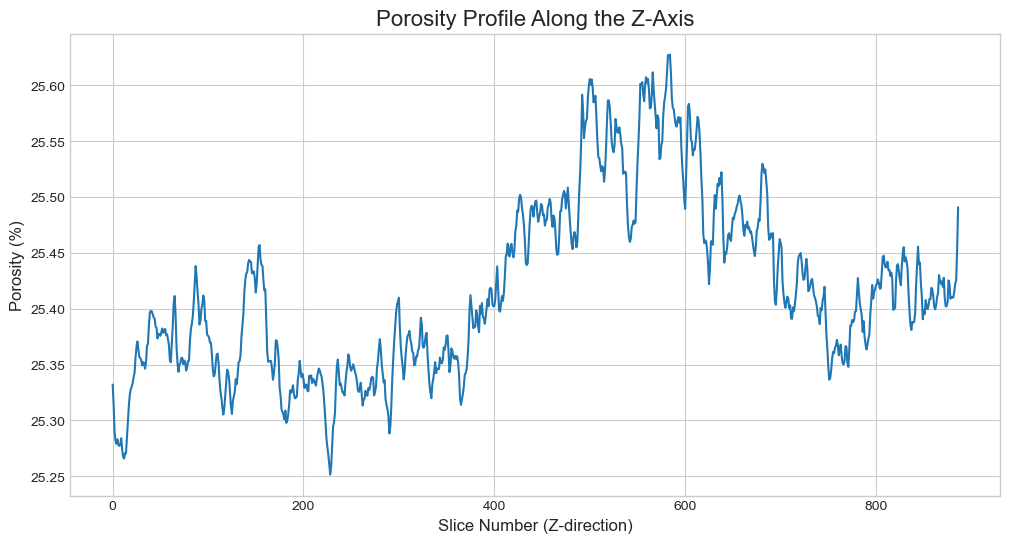

In [ ]:
# Calculate and Plot Porosity

# Assuming pores are represented by non-zero pixels in the segmented images.
# If pores are 0, use `segmented_images == 0`.
total_pixels_per_slice = segmented_images.shape[1] * segmented_images.shape[2]
pore_pixels_per_slice = np.sum(segmented_images == 1 , axis=(1, 2))

# Calculate porosity for each slice
porosity_per_slice = pore_pixels_per_slice / total_pixels_per_slice

# Calculate the overall average porosity
overall_porosity = np.mean(porosity_per_slice)

print(f"Overall Average Porosity (Φ): {overall_porosity:.4f} or {overall_porosity*100:.2f}%")


plt.figure(figsize=(12, 6))
plt.plot(range(NUM_IMAGES), porosity_per_slice * 100)
plt.title('Porosity Profile Along the Z-Axis', fontsize=16)
plt.xlabel('Slice Number (Z-direction)', fontsize=12)
plt.ylabel('Porosity (%)', fontsize=12)
plt.grid(True)
plt.show()

### 7. Porosity per Slice

To get a more detailed understanding of the material's structure, we can analyze how the porosity varies along a specific axis. This cell calculates the porosity for each individual slice and then generates a plot to visualize this distribution. This can reveal important information about the material's homogeneity and any potential gradients in porosity.

Slice 443 Pixel Distribution:
  Value 1: 260038 pixels (25.50%)
  Value 2: 759866 pixels (74.50%)


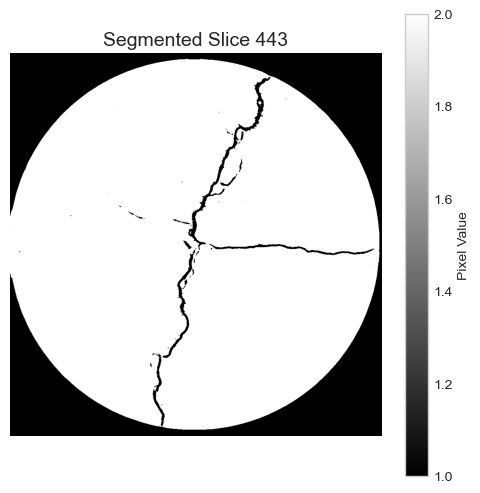

In [7]:
# Choose a slice index to inspect (e.g., middle slice)
slice_index = NUM_IMAGES // 2
slice_image = segmented_images[slice_index]

# Count pixel values
unique, counts = np.unique(slice_image, return_counts=True)
pixel_stats = dict(zip(unique, counts))

# Total pixels in the slice
total_pixels = slice_image.size

# Print pixel distribution and percentages
print(f"Slice {slice_index} Pixel Distribution:")
for value, count in pixel_stats.items():
    percentage = (count / total_pixels) * 100
    print(f"  Value {value}: {count} pixels ({percentage:.2f}%)")

# --- Visualize the slice ---
plt.figure(figsize=(6, 6))
plt.imshow(slice_image, cmap='gray')
plt.title(f'Segmented Slice {slice_index}', fontsize=14)
plt.axis('off')
plt.colorbar(label='Pixel Value')
plt.show()

### 8. 3D Visualization of Pore Space

While 2D slices are useful, a 3D visualization provides a more intuitive understanding of the pore network's structure and connectivity. This cell generates a 3D scatter plot of the pore voxels. To keep the visualization manageable, we only plot a subset of the pore data by downsampling.

Preparing 3D visualization... This may take a moment.


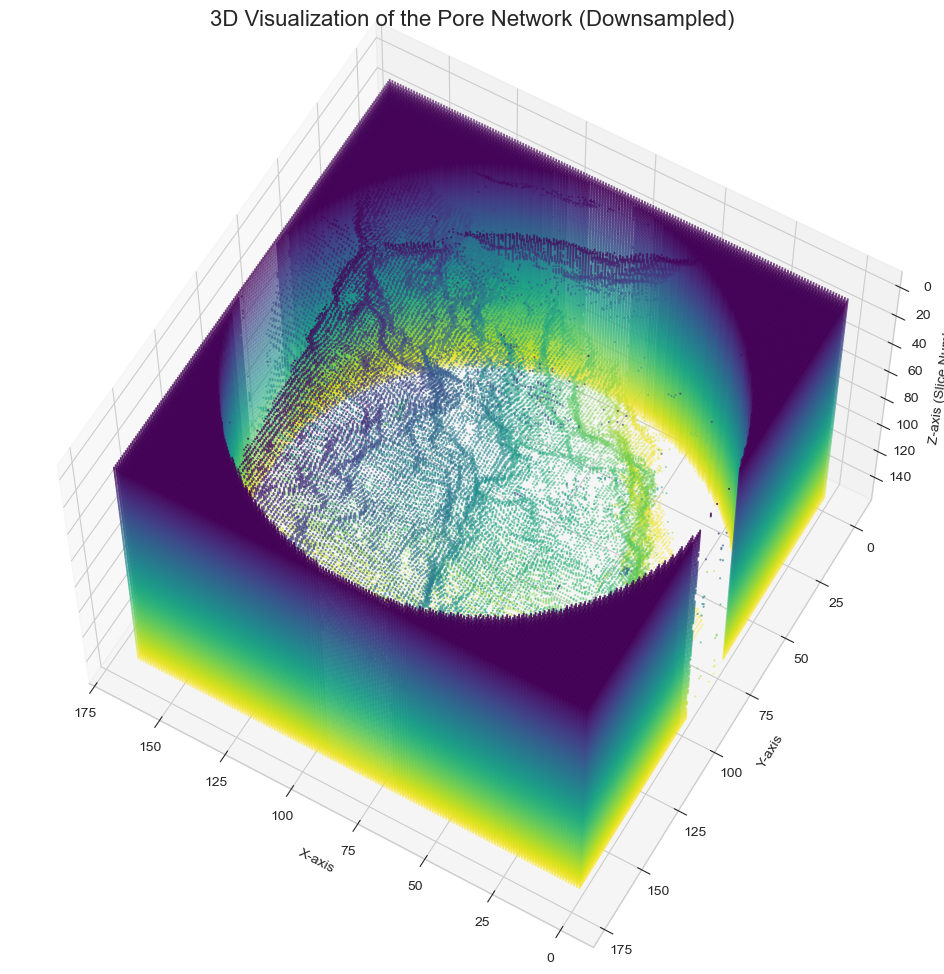

In [ ]:
# 3D Visualization of Pore Space

print("Preparing 3D visualization... This may take a moment.")

# --- Downsample the data to make plotting feasible ---
# A factor of 4 means we take every 4th pixel in each dimension.
downsample_factor = 6
segmented_downsampled = segmented_images[::downsample_factor, ::downsample_factor, ::downsample_factor]

# Get the coordinates of the pore pixels (where pixel value > 0)
z, y, x = np.where(segmented_downsampled == 1)

# --- Create the 3D Scatter Plot ---
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(x, y, z, s=1, c=z, cmap='viridis', marker='.')

ax.set_title('3D Visualization of the Pore Network (Downsampled)', fontsize=16)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis (Slice Number)')

# Invert Z-axis so slice 0 is at the top, like a stack
ax.invert_zaxis()
ax.view_init(elev=60, azim=120)

plt.show()

In [20]:
pip install Vedo

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from vedo import Volume, show, Plotter
import numpy as np

# Create volume from segmented images
pore_volume = Volume(segmented_images)

# Define threshold value for isosurface
threshold_value = np.mean(segmented_images)

# Generate isosurface mesh and apply visual properties
pore_mesh = (
    pore_volume.isosurface(threshold_value)
    .c('cyan')
    .opacity(0.8)
    .lighting('plastic')           # Apply lighting model
)

# Create Plotter in offscreen mode
plotter = Plotter(offscreen=True)


plotter.show(pore_mesh, axes=1, viewup='z', interactive=False)


plotter.screenshot("pore_network.png")


plotter.close()

In [10]:
from vedo import Volume, show, Plotter, settings
import numpy as np

# Optional: improve rendering quality
settings.use_depth_peeling = True

# --- Step 1: Preprocess segmented volume ---
segmented_images = segmented_images.astype(np.float32)
segmented_images /= segmented_images.max()  # Normalize to [0, 1]

# --- Step 2: Create vedo Volume object ---
pore_volume = Volume(segmented_images)

# --- Step 3: Choose threshold for isosurface ---
threshold_value = np.percentile(segmented_images, 30)  # Adjust percentile to capture pores

# --- Step 4: Generate isosurface mesh ---
pore_mesh = (
    pore_volume.isosurface(threshold_value)
    .c('lightblue')               # Color
    .opacity(0.6)                 # Transparency
    .lighting('plastic')         # Lighting model
    .smooth(niter=15)             # Optional smoothing
)

# --- Step 5: Optional volume rendering overlay ---
pore_volume.cmap('bone').alpha([0, 0.1, 0.3, 0.6, 0.8])  # Alpha transfer function

# --- Step 6: Render and save screenshot ---
plotter = Plotter(bg='black', offscreen=True)
plotter.show(pore_volume, pore_mesh, axes=1, viewup='z')
plotter.screenshot("pore_network2.png")

# 🔍 PyTorch CUDA Check Script

This script performs the following tasks:

- ✅ Imports PyTorch and OS libraries
- 📦 Prints the installed PyTorch version
- ⚙️ Displays the CUDA version PyTorch was built with
- 🔍 Checks if CUDA (GPU support) is available
- 🖥️ Retrieves the name of the first available GPU
- 🐞 Enables CUDA launch blocking to help with debugging
- 🚦 Prints a message indicating whether GPU or CPU will be used

In [7]:
import torch

if torch.cuda.is_available():
    print("✅ CUDA is available. You can use GPU.")
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("❌ CUDA is not available. You're using CPU.")

✅ CUDA is available. You can use GPU.
GPU Name: NVIDIA GeForce GTX 1050


In [13]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

2.9.0.dev20250716+cu129
12.9
True
NVIDIA GeForce GTX 1050


## 🧠 Final Data Preparation for Guided Generation (Corrected & Refined)



This cell finalizes the preprocessing pipeline for a guided image generation task using a GAN-like architecture. It prepares three aligned tensors: solid rock images, pore segmentation masks, and real raw images. Key improvements include robust mask handling, circular cropping, and GPU-aware setup.

---

### ⚙️ Setup & Hyperparameters
- Automatically selects CPU (can be extended to GPU).
- Defines image size, batch size, learning rate, and other training parameters.
- Specifies `PORE_VALUES` to identify pore regions in segmentation maps.

---

### 🪨 Stage 1: Solid Rock Image Creation
- Replaces pore regions in `segmented_images` with the median intensity of solid rock pixels.
- Ensures consistent background for guided generation.

---

### 🌀 Stage 2: Circular Mask Application
- Applies a circular mask to crop central regions of the image stack.
- Enhances focus and removes irrelevant borders.

---

### 🧼 Stage 3: Preprocessing Function
- Resizes and normalizes images and masks.
- Uses OpenCV for robust resizing:
  - `cv2.INTER_AREA` for smooth image downsampling.
  - `cv2.INTER_NEAREST` for binary mask preservation.
- Uses `np.isin()` for precise pore binarization.

---

### 📦 Stage 4: Tensor Creation
- Generates three tensors:
  - `input_solid_tensor`: solid rock images.
  - `input_seg_tensor`: binary pore masks.
  - `target_real_tensor`: original raw images.

---

### 🖼️ Stage 5: Verification Plot
- Displays one sample slice from each tensor.
- Un-normalizes and visualizes the processed images for sanity check.

---

### 🚚 Stage 6: DataLoader Creation
- Splits data into training and testing sets.
- Wraps tensors in PyTorch `DataLoader` for efficient batching.

---

✅ **Final Output:** A clean, verified data pipeline ready for training a guided image generation model.

Using device: cpu


Preprocessing images:   0%|          | 0/887 [00:00<?, ?it/s]

Preprocessing masks:   0%|          | 0/887 [00:00<?, ?it/s]

Preprocessing images:   0%|          | 0/887 [00:00<?, ?it/s]


--- Verifying final processed tensors ---


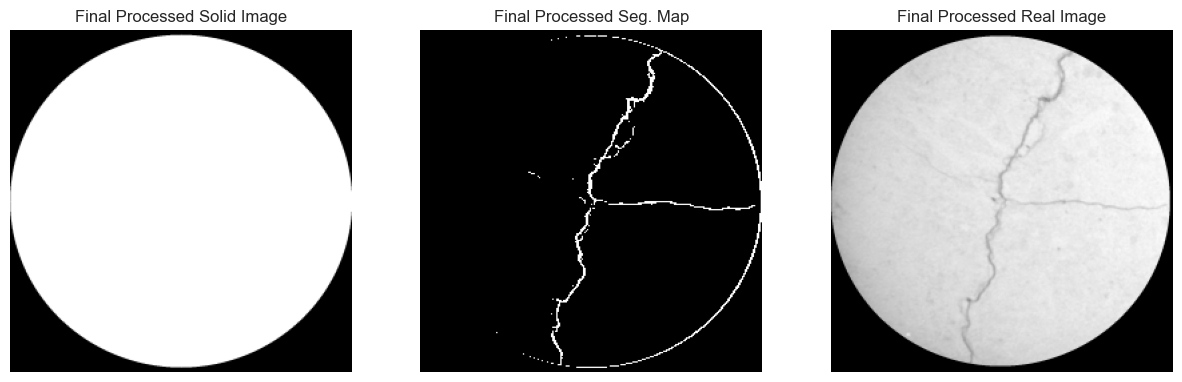


Data pipeline finalized with correct mask handling!


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms.functional import to_tensor, normalize
import torch.nn as nn
import os
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2 # Using OpenCV for robust image resizing

# --- Hyperparameters and Setup ---
DEVICE = "cpu"
IMG_SIZE = 256
BATCH_SIZE = 4
LEARNING_RATE = 2e-4
BETA1 = 0.5
L1_LAMBDA = 100
SAMPLE_SLICE = 440
# --- NEW: Define the exact pixel values that represent pores ---
# Based on your description, pores are values 1 and 2.
# If only 1 is a pore, change this to [1].
PORE_VALUES = [1]

print(f"Using device: {DEVICE}")

# --- Stage 1: Create Solid Rock Images ---
rock_pixels = raw_images[segmented_images == 0]
rock_value = np.median(rock_pixels) if rock_pixels.size > 0 else np.median(raw_images)
solid_rock_images = np.where(segmented_images > 0, rock_value, raw_images)

# --- Stage 2: Apply Circular Mask ---
h, w = raw_images.shape[1], raw_images.shape[2]
center_coordinates = (w // 2, h // 2)
radius = w // 2
Y, X = np.ogrid[:h, :w]
dist_from_center = np.sqrt((X - center_coordinates[0])**2 + (Y-center_coordinates[1])**2)
circular_mask = dist_from_center <= radius

solid_rock_images_masked = solid_rock_images * circular_mask[np.newaxis, :, :]
raw_images_masked = raw_images * circular_mask[np.newaxis, :, :]
segmented_images_masked = segmented_images * circular_mask[np.newaxis, :, :]

# --- Stage 3: Preprocessing Function with Corrected Mask Handling ---
def preprocess_stack(stack, is_mask=False):
    processed_tensors = []
    desc = f"Preprocessing {'masks' if is_mask else 'images'}"
    for img in tqdm(stack, desc=desc):
        if is_mask:
            # This creates a binary map only from the specified PORE_VALUES.
            binary_img = np.isin(img, PORE_VALUES).astype(np.float32)
            img_resized_np = cv2.resize(binary_img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            img_tensor = to_tensor(img_resized_np)
        else:
            img_scaled = img.astype(np.float32) / 65535.0
            img_resized_np = cv2.resize(img_scaled, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
            img_tensor = to_tensor(img_resized_np)
        
        img_normalized = normalize(img_tensor, [0.5], [0.5])
        processed_tensors.append(img_normalized)
    return torch.stack(processed_tensors)

# --- Stage 4: Create all three tensors for the guided model ---
input_solid_tensor = preprocess_stack(solid_rock_images_masked, is_mask=False)
input_seg_tensor = preprocess_stack(segmented_images_masked, is_mask=True)
target_real_tensor = preprocess_stack(raw_images_masked, is_mask=False)

# --- Stage 5: Final Verification Plot ---
print("\n--- Verifying final processed tensors ---")
# Retrieve one sample from each tensor, un-normalize it, and display.
sample_solid = input_solid_tensor[SAMPLE_SLICE].squeeze().numpy() * 0.5 + 0.5
sample_seg = input_seg_tensor[SAMPLE_SLICE].squeeze().numpy() * 0.5 + 0.5
sample_real = target_real_tensor[SAMPLE_SLICE].squeeze().numpy() * 0.5 + 0.5

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample_solid, cmap='gray'); ax[0].set_title(f"Final Processed Solid Image"); ax[0].axis('off')
ax[1].imshow(sample_seg, cmap='gray'); ax[1].set_title(f"Final Processed Seg. Map"); ax[1].axis('off')
ax[2].imshow(sample_real, cmap='gray'); ax[2].set_title(f"Final Processed Real Image"); ax[2].axis('off')
plt.show()

train_dataset = TensorDataset(input_solid_tensor[100:], input_seg_tensor[100:], target_real_tensor[100:])
test_dataset = TensorDataset(input_solid_tensor[:100], input_seg_tensor[:100], target_real_tensor[:100])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("\nData pipeline finalized with correct mask handling!")

## 🧠 Updated Model Architecture

This cell defines the updated **Generator** and **Discriminator** models for a conditional GAN architecture tailored to rock image synthesis. The models are designed to take a **2-channel input** (solid image + segmentation map) and generate a **1-channel output** (synthetic rock image).

### 🔧 UNetBlock
A reusable building block used in both downsampling and upsampling paths of the generator. It supports:
- Instance normalization
- Configurable activation (`ReLU` or `LeakyReLU`)
- Optional dropout for regularization

### 🎨 Generator
A U-Net–based architecture with skip connections to preserve spatial details. Key updates include:
- **Input:** 2 channels (solid + segmentation)
- **Output:** 1 channel (generated rock image)
- **Dropout:** Applied in deeper upsampling layers to improve generalization
- **Activation:** Uses `LeakyReLU` in downsampling and `ReLU` in upsampling

### 🕵️ Discriminator
A PatchGAN-style discriminator that evaluates the realism of the generated image conditioned on the input. Key features:
- **Input:** Concatenated 2-channel condition and 1-channel generated image
- **Architecture:** Progressive convolutional layers with instance normalization
- **Output:** Patch-level realism scores

This setup enables **guided generation** where the model learns to synthesize realistic rock textures based on structural cues from the input segmentation map.

✅ *Models for guided generation defined successfully.*

In [ ]:


# UNetBlock remains the same
class UNetBlock(nn.Module):
    def __init__(self, in_c, out_c, down=True, act="relu", use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False, padding_mode="reflect") if down
            else nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_c),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.conv(x); return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    # --- UPDATE: Takes 2 input channels (solid image + seg map) ---
    def __init__(self, in_channels=2, features=64):
        super().__init__()
        self.initial_down=nn.Sequential(nn.Conv2d(in_channels,features,4,2,1,padding_mode="reflect"),nn.LeakyReLU(0.2))
        self.down1=UNetBlock(features,features*2,down=True,act="leaky")
        self.down2=UNetBlock(features*2,features*4,down=True,act="leaky")
        self.down3=UNetBlock(features*4,features*8,down=True,act="leaky")
        self.down4=UNetBlock(features*8,features*8,down=True,act="leaky")
        self.down5=UNetBlock(features*8,features*8,down=True,act="leaky")
        self.down6=UNetBlock(features*8,features*8,down=True,act="leaky")
        self.bottleneck=nn.Sequential(nn.Conv2d(features*8,features*8,4,2,1),nn.ReLU())
        self.up1=UNetBlock(features*8,features*8,down=False,act="relu",use_dropout=True)
        self.up2=UNetBlock(features*16,features*8,down=False,act="relu",use_dropout=True)
        self.up3=UNetBlock(features*16,features*8,down=False,act="relu",use_dropout=True)
        self.up4=UNetBlock(features*16,features*4,down=False,act="relu")
        self.up5=UNetBlock(features*12,features*2,down=False,act="relu")
        self.up6=UNetBlock(features*6,features,down=False,act="relu")
        self.up7=UNetBlock(features*3,features,down=False,act="relu")
        # --- UPDATE: Outputs 1 channel (the final rock image) ---
        self.final_up=nn.Sequential(nn.ConvTranspose2d(features*2,1,4,2,1),nn.Tanh())
    def forward(self,x):
        d1=self.initial_down(x);d2=self.down1(d1);d3=self.down2(d2);d4=self.down3(d3);d5=self.down4(d4)
        d6=self.down5(d5);d7=self.down6(d6);bottleneck=self.bottleneck(d7)
        up1=self.up1(bottleneck);up2=self.up2(torch.cat([up1,d7],1));up3=self.up3(torch.cat([up2,d6],1))
        up4=self.up4(torch.cat([up3,d5],1));up5=self.up5(torch.cat([up4,d4],1));up6=self.up6(torch.cat([up5,d3],1))
        up7=self.up7(torch.cat([up6,d2],1));return self.final_up(torch.cat([up7,d1],1))

class Discriminator(nn.Module):
    # --- UPDATE: Takes a 2-channel condition (x) and 1-channel image (y) ---
    def __init__(self, in_channels_x=2, in_channels_y=1, features=[64, 128, 256, 512]):
        super().__init__()
        total_in_channels = in_channels_x + in_channels_y
        self.initial=nn.Sequential(nn.Conv2d(total_in_channels,features[0],4,2,1,padding_mode="reflect"),nn.LeakyReLU(0.2))
        layers=[];in_channels=features[0]
        for feature in features[1:]:
            layers.append(nn.Sequential(nn.Conv2d(in_channels,feature,4,1 if feature==features[-1] else 2,1,bias=False,padding_mode="reflect"),nn.InstanceNorm2d(feature),nn.LeakyReLU(0.2)))
            in_channels=feature
        layers.append(nn.Conv2d(in_channels,1,4,1,1,padding_mode="reflect"))
        self.model=nn.Sequential(*layers)
    def forward(self,x,y):
        x=torch.cat([x,y],dim=1);x=self.initial(x);return self.model(x)

print("Models for guided generation defined successfully.")

Models for guided generation defined successfully.


## 🧠 Guided GAN Training with Checkpointing and Final Evaluation

This cell performs the full training and evaluation pipeline for a guided GAN model using solid and segmentation maps as conditional inputs. The workflow includes:

### ⚙️ Configuration & Setup
- Defines training parameters such as number of epochs, checkpoint frequency, and whether to resume from a saved checkpoint.
- Creates necessary directories for saving checkpoints, outputs, and final reports.

### 🏗️ Model Initialization
- Initializes the generator and discriminator models.
- Sets up optimizers (`Adam`) and loss functions (`BCEWithLogitsLoss` for adversarial loss and `L1Loss` for reconstruction fidelity).

### 💾 Checkpoint Loading
- If enabled, loads a saved checkpoint to resume training from a specific epoch.
- Restores model weights, optimizer states, and historical loss values.

### 🔁 Training Loop
- For each epoch:
  - Trains the discriminator to distinguish real vs. generated images.
  - Trains the generator to fool the discriminator and minimize L1 loss against ground truth.
  - Logs generator and discriminator losses.
  - Saves model checkpoints periodically.

### 📦 Final Model Saving
- Saves the final trained generator model to disk.
- Plots and saves the loss curves for both generator and discriminator.

### 📊 Final Evaluation & Report
- Evaluates the trained generator on test data.
- Computes SSIM and PSNR metrics to assess image quality.
- Visualizes input, guidance, GAN output, and ground truth in a comparison grid.
- Saves the evaluation results and prints average SSIM and PSNR scores.

This pipeline ensures robust training with recovery options and provides a comprehensive visual and quantitative report of the GAN's performance.

Loading checkpoint from checkpoints/gan_checkpoint_epoch_18.pth...
Resuming training from epoch 18

--- Starting Guided Adversarial Training ---


GAN Epoch [19/30]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [20/30]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [21/30]:   0%|          | 0/197 [00:00<?, ?it/s]


Saving checkpoint to checkpoints/gan_checkpoint_epoch_21.pth...


GAN Epoch [22/30]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [23/30]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [24/30]:   0%|          | 0/197 [00:00<?, ?it/s]


Saving checkpoint to checkpoints/gan_checkpoint_epoch_24.pth...


GAN Epoch [25/30]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [26/30]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [27/30]:   0%|          | 0/197 [00:00<?, ?it/s]


Saving checkpoint to checkpoints/gan_checkpoint_epoch_27.pth...


GAN Epoch [28/30]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [29/30]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [30/30]:   0%|          | 0/197 [00:00<?, ?it/s]


Saving checkpoint to checkpoints/gan_checkpoint_epoch_30.pth...

--- Training Finished Successfully! Total time: 251.18 minutes ---

Saving final trained generator to guided_final_report/final_generator.pth...


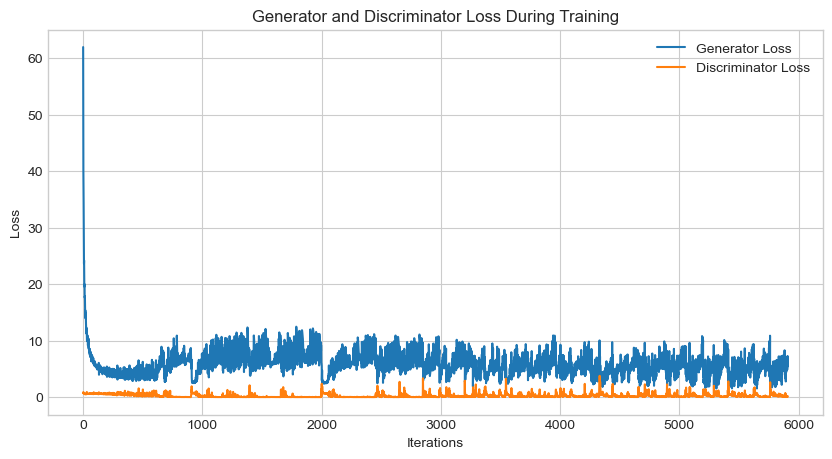


--- Generating Final Report for Guided GAN---


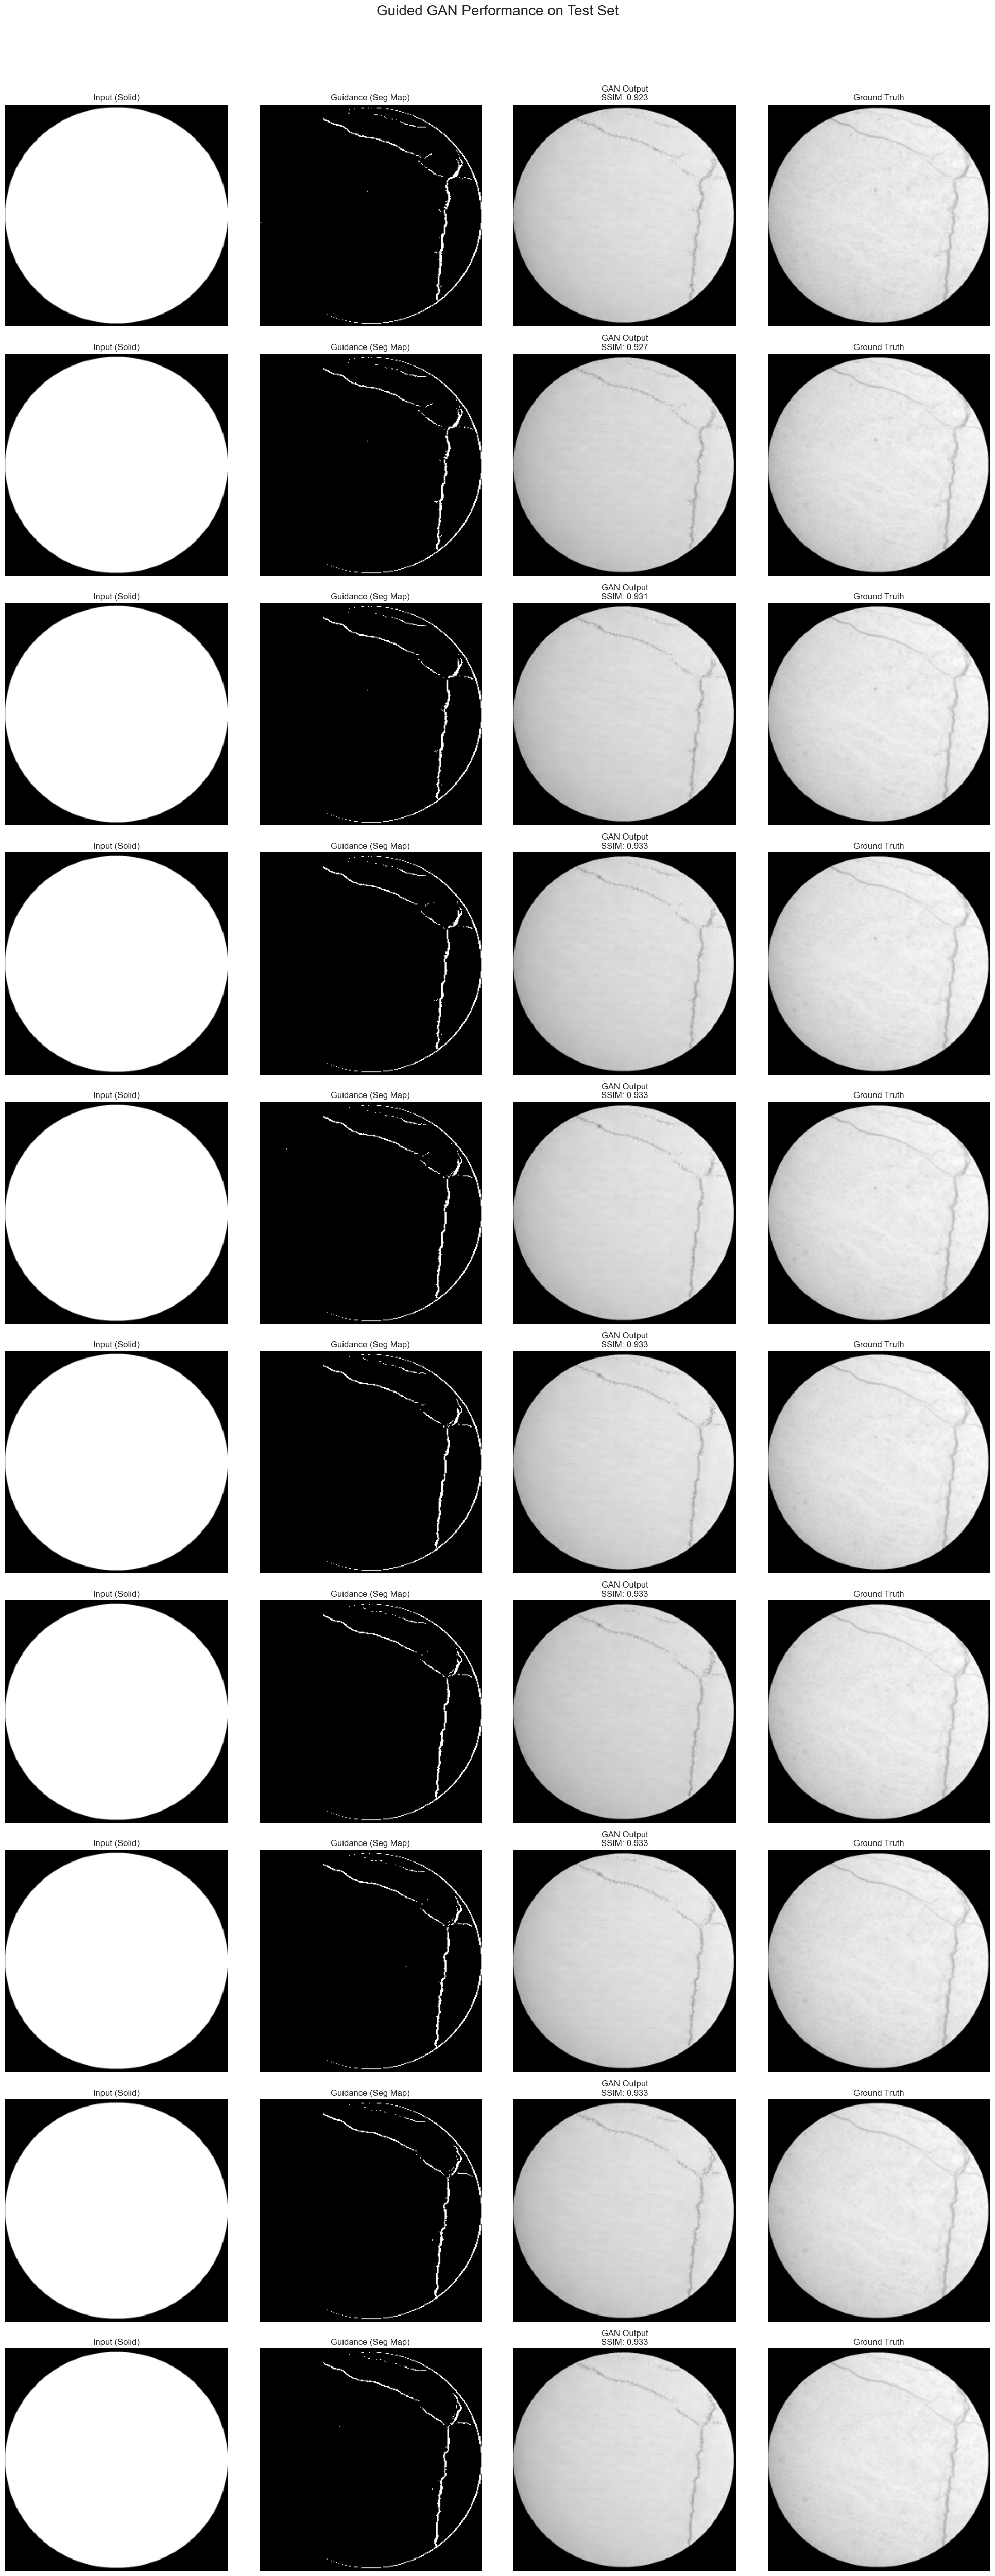


Average SSIM: 0.9312 | Average PSNR: 38.2156 dB

--- Pipeline Finished ---


In [ ]:
# Guided Training with Checkpointing and Final Report

from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import time

# --- Configuration ---
NUM_EPOCHS = 30
SAVE_CHECKPOINT_FREQ = 3 # Save a checkpoint every 15 epochs
LOAD_MODEL = True # Set to True to resume training from a checkpoint
CHECKPOINT_TO_LOAD = "checkpoints/gan_checkpoint_epoch_18.pth" # Path to the checkpoint you want to load

# --- Directory Setup ---
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("guided_gan_outputs", exist_ok=True)
os.makedirs("guided_final_report", exist_ok=True)

# --- Model Initialization ---
gen = Generator().to(DEVICE)
disc = Discriminator().to(DEVICE)
opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1 = nn.L1Loss()

# --- Logic to Load a Checkpoint ---
start_epoch = 0
g_losses = []
d_losses = []

if LOAD_MODEL and os.path.exists(CHECKPOINT_TO_LOAD):
    print(f"Loading checkpoint from {CHECKPOINT_TO_LOAD}...")
    checkpoint = torch.load(CHECKPOINT_TO_LOAD, map_location=DEVICE)
    gen.load_state_dict(checkpoint['gen_state_dict'])
    disc.load_state_dict(checkpoint['disc_state_dict'])
    opt_gen.load_state_dict(checkpoint['opt_gen_state_dict'])
    opt_disc.load_state_dict(checkpoint['opt_disc_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    g_losses = checkpoint.get('g_losses', []) # Use .get for safety
    d_losses = checkpoint.get('d_losses', [])
    print(f"Resuming training from epoch {start_epoch}")
else:
    print("Starting training from scratch.")

# --- Main Guided Training Loop ---
print("\n--- Starting Guided Adversarial Training ---")
total_start_time = time.time()

for epoch in range(start_epoch, NUM_EPOCHS):
    loop = tqdm(train_loader, leave=False, desc=f"GAN Epoch [{epoch+1}/{NUM_EPOCHS}]")
    for idx, (x_solid, x_seg, y_true) in enumerate(loop):
        x_solid, x_seg, y_true = x_solid.to(DEVICE), x_seg.to(DEVICE), y_true.to(DEVICE)
        
        x_condition = torch.cat([x_solid, x_seg], dim=1)
        
        # Train Discriminator
        y_fake = gen(x_condition)
        D_real = disc(x_condition, y_true); D_fake = disc(x_condition, y_fake.detach())
        D_loss = (BCE(D_real, torch.ones_like(D_real)) + BCE(D_fake, torch.zeros_like(D_fake)))/2
        disc.zero_grad(); D_loss.backward(); opt_disc.step()

        # Train Generator
        D_fake = disc(x_condition, y_fake)
        G_loss = BCE(D_fake, torch.ones_like(D_fake)) + L1(y_fake, y_true) * L1_LAMBDA
        gen.zero_grad(); G_loss.backward(); opt_gen.step()
        
        # Log losses for plotting
        g_losses.append(G_loss.item())
        d_losses.append(D_loss.item())
        loop.set_postfix(D_loss=D_loss.item(),G_loss=G_loss.item())
    
    # --- Save Checkpoint Periodically ---
    if (epoch + 1) % SAVE_CHECKPOINT_FREQ == 0:
        checkpoint_path = f"checkpoints/gan_checkpoint_epoch_{epoch+1}.pth"
        print(f"\nSaving checkpoint to {checkpoint_path}...")
        torch.save({
            'epoch': epoch,
            'gen_state_dict': gen.state_dict(),
            'disc_state_dict': disc.state_dict(),
            'opt_gen_state_dict': opt_gen.state_dict(),
            'opt_disc_state_dict': opt_disc.state_dict(),
            'g_losses': g_losses,
            'd_losses': d_losses,
        }, checkpoint_path)

print(f"\n--- Training Finished Successfully! Total time: {(time.time() - total_start_time)/60:.2f} minutes ---")

# --- Save the Final Trained Generator ---
final_model_path = "guided_final_report/final_generator.pth"
print(f"\nSaving final trained generator to {final_model_path}...")
torch.save(gen.state_dict(), final_model_path)

# --- Plot Training Losses ---
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("guided_final_report/loss_plot.png")
plt.show()

# --- Final Evaluation and Report ---
print("\n--- Generating Final Report for Guided GAN---")
gen.eval()
ssim_scores, psnr_scores = [], []
num_report_images = 10 

fig, axes = plt.subplots(num_report_images, 4, figsize=(20, 5 * num_report_images))
fig.suptitle('Guided GAN Performance on Test Set', fontsize=20, y=1.0)

with torch.no_grad():
    for i, (x_solid, x_seg, y_true) in enumerate(test_loader):
        if i >= num_report_images: break
        x_solid, x_seg, y_true = x_solid.to(DEVICE), x_seg.to(DEVICE), y_true.to(DEVICE)
        
        x_condition = torch.cat([x_solid, x_seg], dim=1)
        y_gan = gen(x_condition)
        
        img_solid = x_solid[0,0].cpu().numpy()*0.5+0.5
        img_seg = x_seg[0,0].cpu().numpy()*0.5+0.5
        img_true = y_true[0,0].cpu().numpy()*0.5+0.5
        img_gan = y_gan[0,0].cpu().numpy()*0.5+0.5
        
        s=ssim(img_true, img_gan, data_range=1.0); p=psnr(img_true, img_gan, data_range=1.0)
        ssim_scores.append(s); psnr_scores.append(p)
        
        axes[i, 0].imshow(img_solid, cmap='gray'); axes[i, 0].set_title("Input (Solid)"); axes[i, 0].axis('off')
        axes[i, 1].imshow(img_seg, cmap='gray'); axes[i, 1].set_title("Guidance (Seg Map)"); axes[i, 1].axis('off')
        axes[i, 2].imshow(img_gan, cmap='gray'); axes[i, 2].set_title(f"GAN Output\nSSIM: {s:.3f}"); axes[i, 2].axis('off')
        axes[i, 3].imshow(img_true, cmap='gray'); axes[i, 3].set_title("Ground Truth"); axes[i, 3].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.98]); plt.savefig("guided_final_report/comparison_grid.png"); plt.show()
print(f"\nAverage SSIM: {np.mean(ssim_scores):.4f} | Average PSNR: {np.mean(psnr_scores):.4f} dB")
print("\n--- Pipeline Finished ---")

## 🔍 Cell 13: GAN Checkpoint Analysis & Reporting

This cell loads a trained GAN generator from a specified checkpoint and performs a detailed evaluation on the test set.

### Steps:
- **Load Checkpoint**: Restores the generator model and sets it to evaluation mode.
- **Generate Predictions**: Runs the model on test inputs and collects outputs.
- **Visualize Errors**: Creates per-pixel absolute error maps comparing GAN outputs to ground truth.
- **Save Results**: Stores visual comparisons in `final_report/error_maps`.

The error maps provide insight into where the model performs well and where it struggles, supporting deeper analysis for your thesis.


      ADVANCED REPORTING & ANALYSIS FOR THESIS
Analysis will be performed on model: checkpoints/gan_checkpoint_epoch_30.pth
Trained model loaded successfully.

[1/5] Gathering all test set predictions...


Processing Test Set:   0%|          | 0/100 [00:00<?, ?it/s]


[2/5] Generating per-pixel error maps...


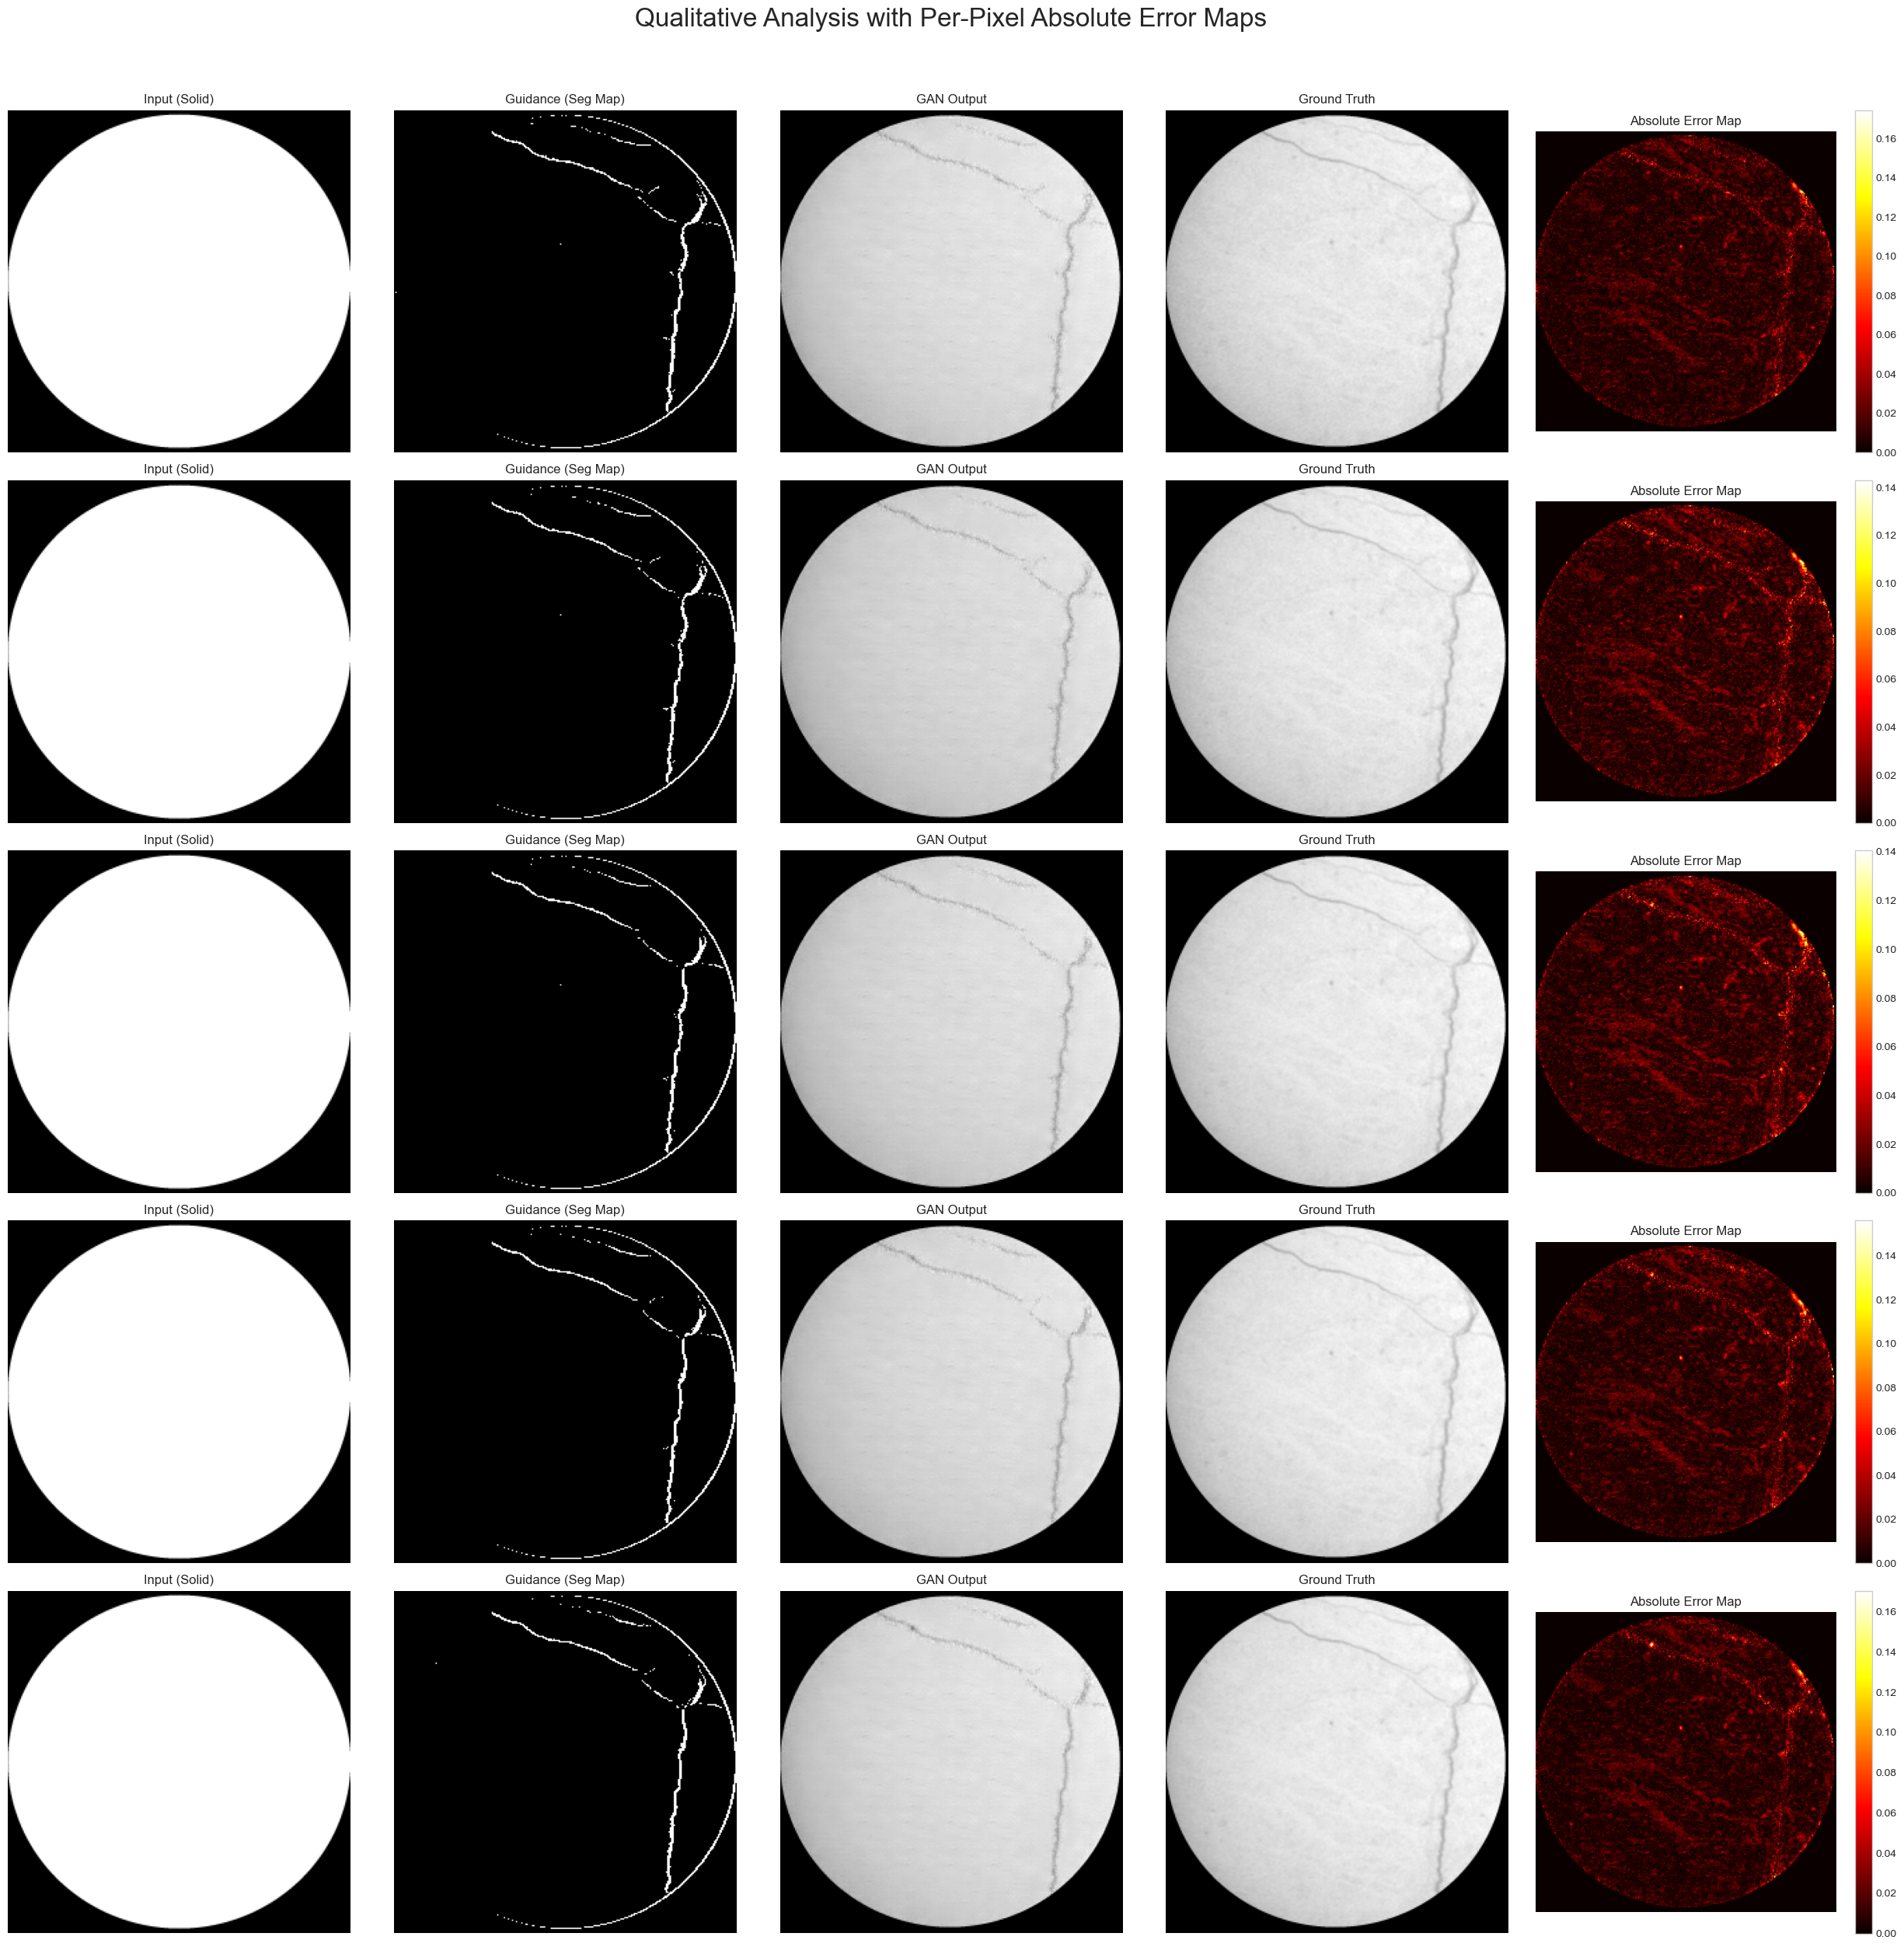

In [ ]:
# Advanced Reporting and Analysis from a Saved Checkpoint

import seaborn as sns
from scipy.stats import pearsonr
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- 1. Configuration: Specify which checkpoint to load ---
# IMPORTANT: Change this path to point to the checkpoint you want to analyze.
# This would typically be the one from the last epoch, or your best-performing one.
MODEL_CHECKPOINT_PATH = "checkpoints/gan_checkpoint_epoch_30.pth" 

print("\n" + "="*50)
print("      ADVANCED REPORTING & ANALYSIS FOR THESIS")
print("="*50)
print(f"Analysis will be performed on model: {MODEL_CHECKPOINT_PATH}")

# --- 2. Load the Trained Generator from the Checkpoint File ---
# Instantiate the model architecture (the class definition must be available in the notebook)
gen = Generator().to(DEVICE)

# Load the checkpoint dictionary onto the correct device (CPU or GPU)
checkpoint = torch.load(MODEL_CHECKPOINT_PATH, map_location=DEVICE)

# Load the generator's state dictionary from the checkpoint into the model instance
gen.load_state_dict(checkpoint['gen_state_dict'])

# Set the model to evaluation mode. This is crucial as it disables layers like Dropout.
gen.eval() 

print("Trained model loaded successfully.")

# --- 3. Run the Full Analysis Suite ---
# Create dedicated directories for the report figures
os.makedirs("final_report/error_maps", exist_ok=True)
os.makedirs("final_report/analysis_plots", exist_ok=True)

# Gather all predictions from the test set first
print("\n[1/5] Gathering all test set predictions...")
all_gans, all_reals, all_solids, all_segs = [], [], [], []
with torch.no_grad():
    for x_solid, x_seg, y_true in tqdm(test_loader, desc="Processing Test Set"):
        x_solid, x_seg = x_solid.to(DEVICE), x_seg.to(DEVICE)
        
        x_condition = torch.cat([x_solid, x_seg], dim=1)
        y_gan = gen(x_condition)
        
        # Un-normalize and store results as numpy arrays
        all_solids.append(x_solid[0,0].cpu().numpy() * 0.5 + 0.5)
        all_segs.append(x_seg[0,0].cpu().numpy() * 0.5 + 0.5)
        all_gans.append(y_gan[0,0].cpu().numpy() * 0.5 + 0.5)
        all_reals.append(y_true[0,0].numpy() * 0.5 + 0.5)

# Convert lists to numpy arrays for easier processing
all_gans = np.array(all_gans)
all_reals = np.array(all_reals)
all_solids = np.array(all_solids)
all_segs = np.array(all_segs)

# --- Analysis 1: Per-Pixel Error Visualization ---
print("\n[2/5] Generating per-pixel error maps...")
num_error_maps = 5
fig, axes = plt.subplots(num_error_maps, 5, figsize=(25, 5 * num_error_maps))
fig.suptitle('Qualitative Analysis with Per-Pixel Absolute Error Maps', fontsize=24, y=1.0)

for i in range(num_error_maps):
    error_map = np.abs(all_reals[i] - all_gans[i])
    axes[i, 0].imshow(all_solids[i], cmap='gray'); axes[i, 0].set_title("Input (Solid)"); axes[i, 0].axis('off')
    axes[i, 1].imshow(all_segs[i], cmap='gray'); axes[i, 1].set_title("Guidance (Seg Map)"); axes[i, 1].axis('off')
    axes[i, 2].imshow(all_gans[i], cmap='gray'); axes[i, 2].set_title("GAN Output"); axes[i, 2].axis('off')
    axes[i, 3].imshow(all_reals[i], cmap='gray'); axes[i, 3].set_title("Ground Truth"); axes[i, 3].axis('off')
    im = axes[i, 4].imshow(error_map, cmap='hot'); axes[i, 4].set_title("Absolute Error Map"); axes[i, 4].axis('off')
    fig.colorbar(im, ax=axes[i, 4])

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("final_report/error_maps/error_map_comparison.png")
plt.show()

## 📊 Pixel Intensity Distribution Report

Compares the pixel intensity distributions of GAN-generated outputs vs. ground truth using KDE plots.

- **Visual Output**: Saved as `intensity_distribution.png`
- **Stats**: Mean and standard deviation printed for both sets

This helps assess how closely the GAN mimics the real data's intensity profile.


[3/5] Generating pixel intensity distribution report...


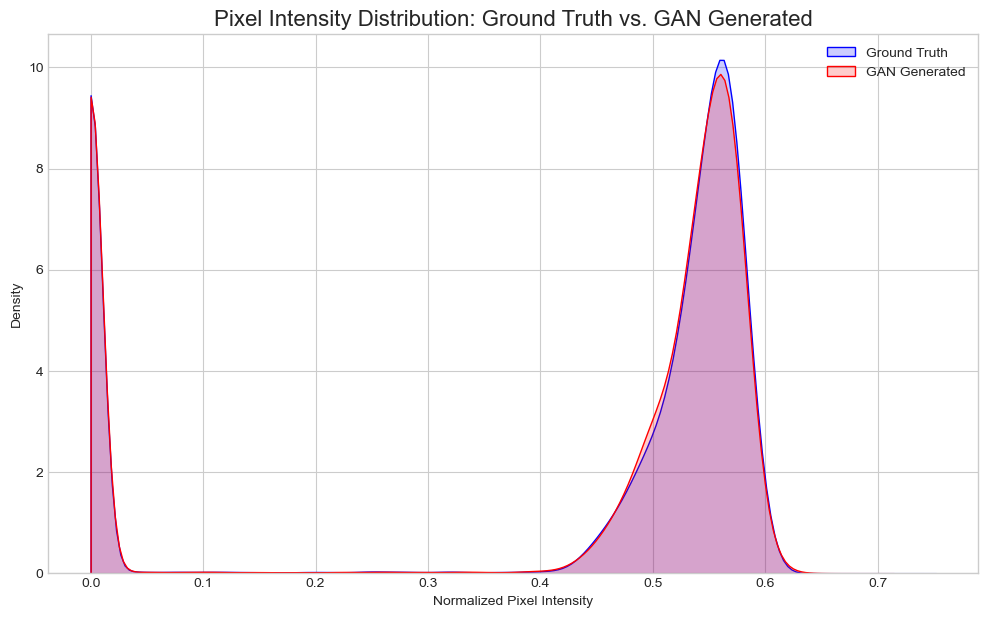


--- Intensity Statistics ---
Ground Truth Mean Intensity: 0.4091 | Std Dev: 0.2356
GAN Generated Mean Intensity: 0.4085 | Std Dev: 0.2350


In [56]:

# --- Analysis 2: Pixel Intensity Distribution Report ---
print("\n[3/5] Generating pixel intensity distribution report...")
plt.figure(figsize=(12, 7))
sns.kdeplot(all_reals.flatten(), label='Ground Truth', color='blue', fill=True, alpha=0.2, clip=(0,1))
sns.kdeplot(all_gans.flatten(), label='GAN Generated', color='red', fill=True, alpha=0.2, clip=(0,1))
plt.title('Pixel Intensity Distribution: Ground Truth vs. GAN Generated', fontsize=16)
plt.xlabel('Normalized Pixel Intensity')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.savefig("final_report/analysis_plots/intensity_distribution.png")
plt.show()

print("\n--- Intensity Statistics ---")
print(f"Ground Truth Mean Intensity: {np.mean(all_reals):.4f} | Std Dev: {np.std(all_reals):.4f}")
print(f"GAN Generated Mean Intensity: {np.mean(all_gans):.4f} | Std Dev: {np.std(all_gans):.4f}")

## 🔬 Frequency Domain Analysis

Performs 2D Fourier analysis on a sample to compare texture and structural frequency content.

- **Output**: Log-magnitude spectra of ground truth vs. GAN output
- **Visualization**: Saved as `frequency_analysis.png`

Low frequencies (center) represent global structure; high frequencies (edges) capture fine textures. Similar spectra suggest the GAN is learning realistic texture patterns.


[5/5] Generating frequency domain (texture) analysis...


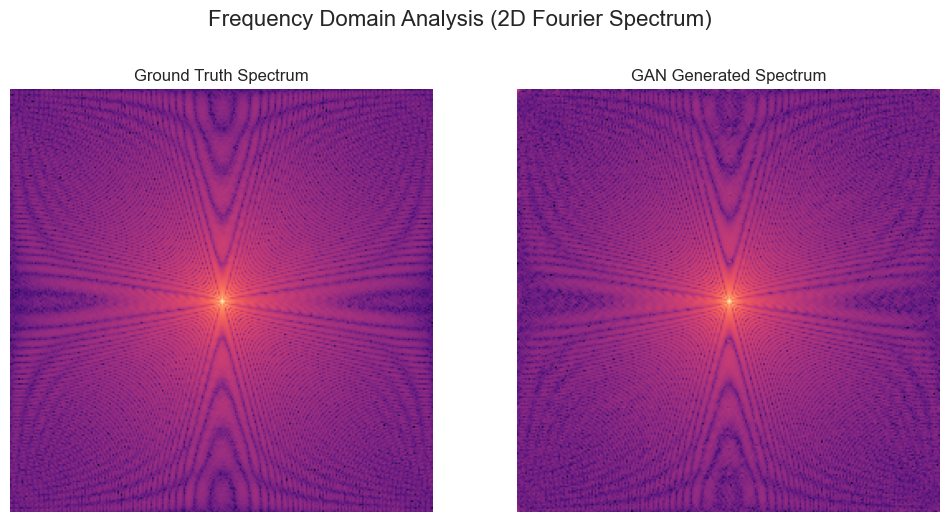

Frequency analysis explanation: The center represents low frequencies (overall shapes), while the edges represent high frequencies (fine textures and noise). Similar patterns indicate the GAN is learning the correct texture properties.


--- All Reporting and Analysis Complete! ---


In [57]:

# --- Analysis 4: Frequency Domain Analysis ---
print("\n[5/5] Generating frequency domain (texture) analysis...")
# Pick one good example to analyze
sample_idx = 5 
real_sample_fft = np.fft.fftshift(np.fft.fft2(all_reals[sample_idx]))
gan_sample_fft = np.fft.fftshift(np.fft.fft2(all_gans[sample_idx]))

# Calculate log magnitude spectrum
real_fft_mag = 20 * np.log(np.abs(real_sample_fft))
gan_fft_mag = 20 * np.log(np.abs(gan_sample_fft))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Frequency Domain Analysis (2D Fourier Spectrum)', fontsize=16)
ax[0].imshow(real_fft_mag, cmap='magma'); ax[0].set_title('Ground Truth Spectrum'); ax[0].axis('off')
ax[1].imshow(gan_fft_mag, cmap='magma'); ax[1].set_title('GAN Generated Spectrum'); ax[1].axis('off')
plt.savefig("final_report/analysis_plots/frequency_analysis.png")
plt.show()
print("Frequency analysis explanation: The center represents low frequencies (overall shapes), while the edges represent high frequencies (fine textures and noise). Similar patterns indicate the GAN is learning the correct texture properties.")

print("\n\n--- All Reporting and Analysis Complete! ---")

## 🧠 Final Comprehensive Analysis: Physical Properties of Generated vs. Real Rocks

This cell performs a **three-part analysis** comparing the GAN-generated microstructures with ground truth data from real rock samples. Unlike pixel-wise GAN evaluation metrics (e.g., loss, SSIM, FID), these analyses focus on **physical characteristics** that are critical in geoscience and reservoir engineering.

> ⚠️ **Important Note:**  
> The results from this cell **may differ significantly** from GAN evaluation metrics. This is expected and **not a flaw**—these metrics assess **physical realism**, not just visual similarity. They reflect how well the GAN captures **porosity**, **connectivity**, and **spatial structure**, which are essential for understanding fluid flow and permeability in porous media.

---

### 🔍 Analysis A: Porosity Correlation
- Measures the fraction of pore space in each image.
- Compares porosity values between real and GAN-generated samples.
- Uses **Pearson correlation** to quantify agreement.
- Includes a **robustness check** for zero variance to avoid misleading results.

---

### 🔗 Analysis B: Topological Connectivity (Euler Number)
- Uses the **Euler characteristic** as a proxy for connectivity and permeability.
- A higher Euler number typically indicates more disconnected pore regions.
- Again, correlation is computed with robustness checks.
- This metric is **topological**, not pixel-based—making it a strong indicator of fluid transport potential.

---

### 📐 Analysis C: Two-Point Probability Function ($S_2$)
- Captures **spatial correlations** in pore structure.
- Measures the probability that two points separated by a distance \( r \) both lie in the pore space.
- Computed using **FFT-based autocorrelation** and **radial averaging**.
- No correlation metric is used here—this is a **distributional comparison**.

---

### 📁 Output
All plots are saved to `final_report/analysis_plots/` for inclusion in your thesis or further inspection.

---

### ✅ Summary
This analysis provides a **physically grounded evaluation** of the GAN's performance. It goes beyond visual similarity to assess whether the generated samples **behave like real porous media** in terms of structure and connectivity. These metrics are crucial for applications in **reservoir simulation**, **fluid dynamics**, and **material science**.



      FINAL COMPREHENSIVE ANALYSIS FOR THESIS
Loaded model from: checkpoints/gan_checkpoint_epoch_30.pth

Gathering all test set predictions...


Processing Test Set:   0%|          | 0/100 [00:00<?, ?it/s]

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Binarization complete using a GAN pore threshold of 0.2819

--- Starting Analysis A: Porosity Correlation ---


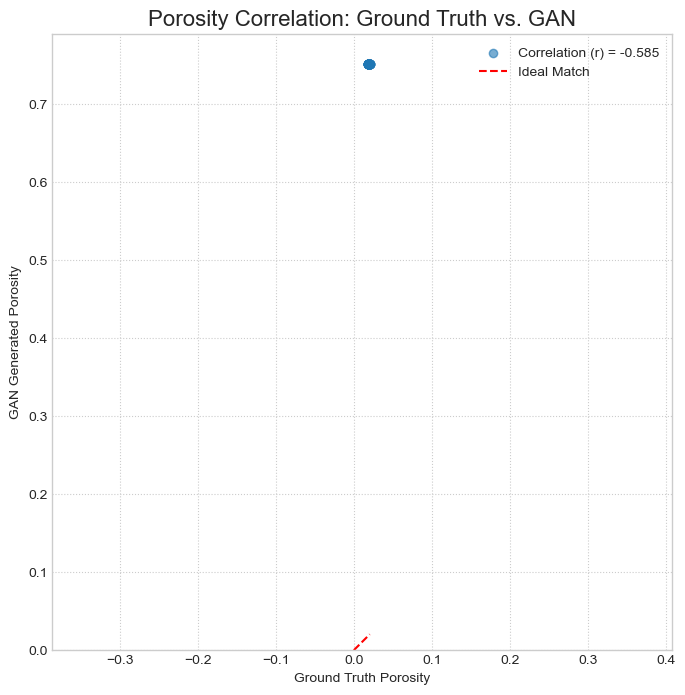


--- Starting Analysis B: Topological Connectivity (Permeability Proxy) ---


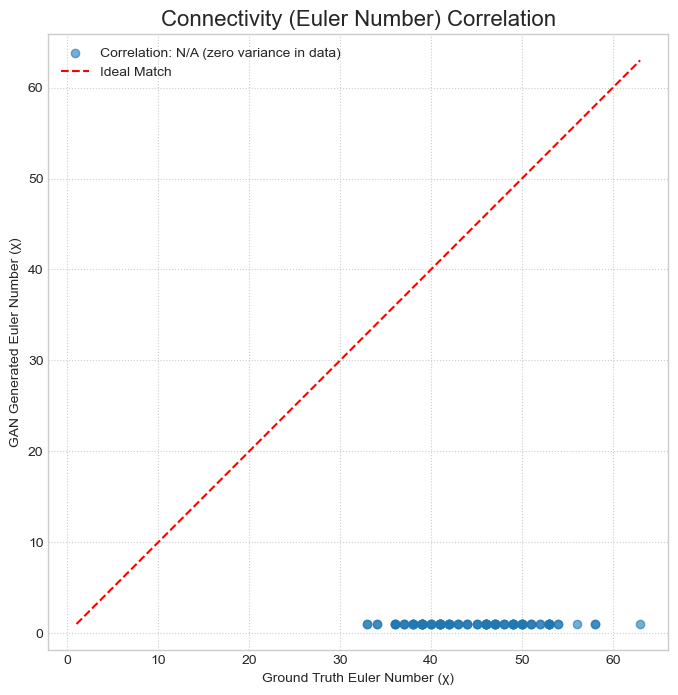


--- Starting Analysis C: Two-Point Probability Function ---


Calculating S2 Functions:   0%|          | 0/100 [00:00<?, ?it/s]

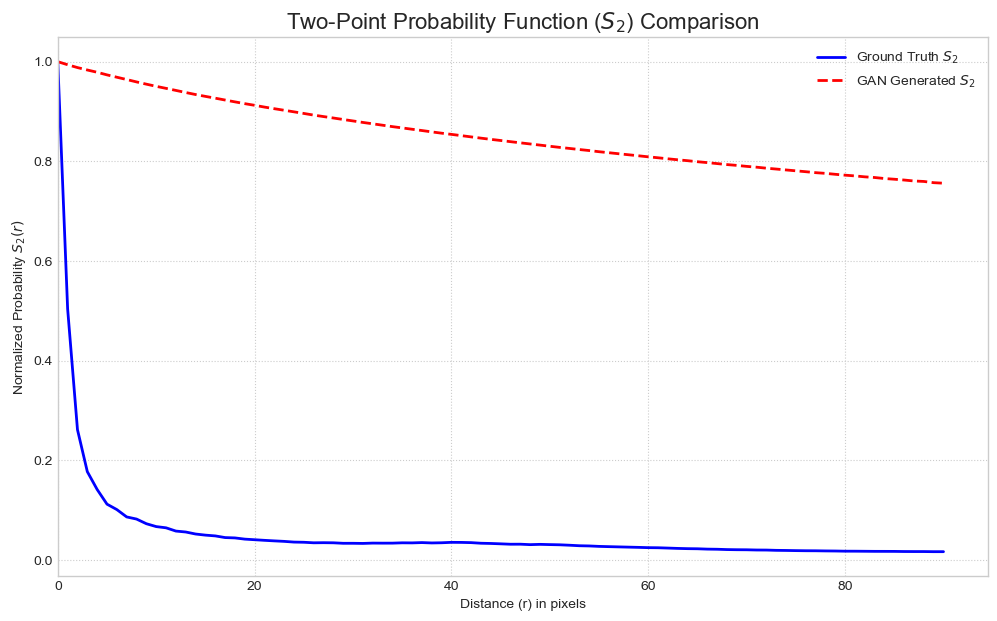



--- All Analyses Complete! ---


In [58]:
# Final Analysis Cell: Porosity, Connectivity (Permeability Proxy), and Two-Point Correlation

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
from scipy import ndimage
from skimage import measure

# --- 1. Configuration ---
MODEL_CHECKPOINT_PATH = "checkpoints/gan_checkpoint_epoch_30.pth" # CHANGE THIS to your checkpoint

print("\n" + "="*50)
print("      FINAL COMPREHENSIVE ANALYSIS FOR THESIS")
print("="*50)

# --- 2. Load Model and Gather Predictions ---
gen = Generator().to(DEVICE)
checkpoint = torch.load(MODEL_CHECKPOINT_PATH, map_location=DEVICE)
gen.load_state_dict(checkpoint['gen_state_dict'])
gen.eval()
print(f"Loaded model from: {MODEL_CHECKPOINT_PATH}")

os.makedirs("final_report/analysis_plots", exist_ok=True)

print("\nGathering all test set predictions...")
all_gans, all_reals, all_segs = [], [], []
with torch.no_grad():
    for x_solid, x_seg, y_true in tqdm(test_loader, desc="Processing Test Set"):
        x_solid, x_seg = x_solid.to(DEVICE), x_seg.to(DEVICE)
        x_condition = torch.cat([x_solid, x_seg], dim=1)
        y_gan = gen(x_condition)
        all_segs.append(x_seg[0,0].cpu().numpy() * 0.5 + 0.5)
        all_gans.append(y_gan[0,0].cpu().numpy() * 0.5 + 0.5)
        all_reals.append(y_true[0,0].numpy() * 0.5 + 0.5)

all_gans = np.array(all_gans); all_reals = np.array(all_reals); all_segs = np.array(all_segs)

# --- 3. Binarize Images ---
binary_reals = (all_segs > 0.5).astype(int)
pore_pixel_values_real = all_reals[binary_reals == 1]
pore_threshold = np.mean(pore_pixel_values_real) if pore_pixel_values_real.size > 0 else 0.5
binary_gans = (all_gans > pore_threshold).astype(int)
print(f"Binarization complete using a GAN pore threshold of {pore_threshold:.4f}")

# ==============================================================================
# --- Analysis A: Porosity Correlation (Robust Version) ---
# ==============================================================================
print("\n--- Starting Analysis A: Porosity Correlation ---")
porosity_real = np.mean(binary_reals, axis=(1, 2))
porosity_gan = np.mean(binary_gans, axis=(1, 2))

# ROBUSTNESS FIX: Check for zero variance before calculating correlation
if np.var(porosity_gan) > 0 and np.var(porosity_real) > 0:
    corr_porosity, _ = pearsonr(porosity_real, porosity_gan)
    corr_label = f'Correlation (r) = {corr_porosity:.3f}'
else:
    corr_label = 'Correlation: N/A (zero variance in data)'
    print("Warning: Porosity correlation could not be calculated. This is expected if the model is under-trained.")

plt.figure(figsize=(8, 8)); plt.scatter(porosity_real, porosity_gan, alpha=0.6, label=corr_label)
plt.plot([0, np.max(porosity_real)], [0, np.max(porosity_real)], 'r--', label='Ideal Match')
plt.title('Porosity Correlation: Ground Truth vs. GAN', fontsize=16); plt.xlabel('Ground Truth Porosity'); plt.ylabel('GAN Generated Porosity')
plt.grid(True, linestyle=':'); plt.legend(); plt.axis('equal'); plt.xlim(left=0); plt.ylim(bottom=0)
plt.savefig("final_report/analysis_plots/A_porosity_correlation.png"); plt.show()

# ==============================================================================
# --- Analysis B: Topological Connectivity (Robust Version) ---
# ==============================================================================
print("\n--- Starting Analysis B: Topological Connectivity (Permeability Proxy) ---")
def calculate_euler_number_2d(binary_image):
    return measure.euler_number(measure.label(binary_image, connectivity=2, background=0), connectivity=2)

euler_reals = np.array([calculate_euler_number_2d(img) for img in binary_reals])
euler_gans = np.array([calculate_euler_number_2d(img) for img in binary_gans])

# ROBUSTNESS FIX: Check for zero variance before calculating correlation
if np.var(euler_gans) > 0 and np.var(euler_reals) > 0:
    corr_euler, _ = pearsonr(euler_reals, euler_gans)
    corr_label_euler = f'Correlation (r) = {corr_euler:.3f}'
else:
    corr_label_euler = 'Correlation: N/A (zero variance in data)'
    print("Warning: Euler number correlation could not be calculated. This is expected if the model is under-trained.")

plt.figure(figsize=(8, 8)); plt.scatter(euler_reals, euler_gans, alpha=0.6, label=corr_label_euler)
min_val = min(euler_reals.min(), euler_gans.min()); max_val = max(euler_reals.max(), euler_gans.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Match')
plt.title('Connectivity (Euler Number) Correlation', fontsize=16); plt.xlabel('Ground Truth Euler Number (χ)'); plt.ylabel('GAN Generated Euler Number (χ)')
plt.grid(True, linestyle=':'); plt.legend(); plt.axis('equal')
plt.savefig("final_report/analysis_plots/B_connectivity_correlation.png"); plt.show()

# ==============================================================================
# --- Analysis C: Two-Point Probability Function ---
# ==============================================================================
# (This analysis does not require a correlation value and is robust to under-trained models)
print("\n--- Starting Analysis C: Two-Point Probability Function ---")
# Functions are defined here for clarity, even if defined before
def calculate_s2_fft(img): return np.fft.fftshift(np.fft.ifftn(np.abs(np.fft.fftn(img))**2)).real
def radial_profile(data):
    center=(data.shape[0]//2,data.shape[1]//2); y,x=np.indices((data.shape)); r=np.sqrt((x-center[0])**2+(y-center[1])**2)
    r=r.astype(int); tbin=np.bincount(r.ravel(),data.ravel()); nr=np.bincount(r.ravel())
    return np.divide(tbin,nr,out=np.zeros_like(tbin,dtype=float),where=nr!=0)

s2_reals, s2_gans = [], []
for i in tqdm(range(len(binary_reals)), desc="Calculating S2 Functions"):
    real_ac = calculate_s2_fft(binary_reals[i]); gan_ac = calculate_s2_fft(binary_gans[i])
    if real_ac.max() > 0: real_ac /= real_ac.max()
    if gan_ac.max() > 0: gan_ac /= gan_ac.max()
    s2_reals.append(radial_profile(real_ac)); s2_gans.append(radial_profile(gan_ac))

s2_real_avg = np.mean(s2_reals, axis=0); s2_gan_avg = np.mean(s2_gans, axis=0)
plt.figure(figsize=(12, 7)); max_r = len(s2_real_avg)//2
plt.plot(s2_real_avg[:max_r], label='Ground Truth $S_2$', c='blue', lw=2)
plt.plot(s2_gan_avg[:max_r], label='GAN Generated $S_2$', c='red', ls='--', lw=2)
plt.title('Two-Point Probability Function ($S_2$) Comparison', fontsize=16); plt.xlabel('Distance (r) in pixels'); plt.ylabel('Normalized Probability $S_2(r)$')
plt.legend(); plt.grid(True, linestyle=':'); plt.xlim(left=0)
plt.savefig("final_report/analysis_plots/C_s2_correlation_plot.png"); plt.show()

print("\n\n--- All Analyses Complete! ---")

## 🧪 Individual Sample Analysis & Saving

This cell performs a detailed analysis of five specific samples from the test dataset using a trained GAN model. The goal is to compare the real and generated pore structures in terms of porosity and connectivity.

### 🔧 Configuration
- **Model Checkpoint:** `gan_checkpoint_epoch_18.pth`
- **Sample Indices:** `[15, 30, 45, 60, 75]`
- **Output Directory:** `final_report/sample_analysis/`

### 🧠 Workflow Overview
1. **Model Loading:** Loads the trained generator from the specified checkpoint.
2. **Sample Processing:** For each selected index:
   - Retrieves solid and segmentation tensors.
   - Generates synthetic pore structure using the GAN.
   - Converts tensors to NumPy arrays and un-normalizes them.
   - Applies thresholding to create binary masks.
3. **Metric Calculation:**
   - **Porosity:** Ratio of pore pixels to total segmented area.
   - **Connectivity:** Euler number computed via `calculate_euler_number_2d`.
4. **Image Saving:** Saves both real and GAN-generated images for each sample.
5. **Report Generation:** Displays a summary table of metrics for all samples.

### 📊 Output
- A formatted table showing porosity and connectivity metrics for each sample.
- Saved image pairs (`REAL` and `GAN`) in the specified output directory.

This analysis helps evaluate the GAN's ability to replicate realistic pore structures and maintain topological features.

In [59]:
# New Cell: Save and Analyze Individual Samples

import pandas as pd

# --- Configuration ---
MODEL_CHECKPOINT_PATH = "checkpoints/gan_checkpoint_epoch_30.pth" # Use the same checkpoint
SAMPLE_INDICES = [15, 30, 45, 60, 75] # Choose 5 specific indices from the test set
OUTPUT_DIR = "final_report/sample_analysis/"

print("\n" + "="*50)
print("      INDIVIDUAL SAMPLE ANALYSIS & SAVING")
print("="*50)

# --- Load Model ---
gen = Generator().to(DEVICE)
checkpoint = torch.load(MODEL_CHECKPOINT_PATH, map_location=DEVICE)
gen.load_state_dict(checkpoint['gen_state_dict'])
gen.eval()
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Loaded model from: {MODEL_CHECKPOINT_PATH}")

# --- Analysis Loop ---
results_data = []

with torch.no_grad():
    for i in tqdm(SAMPLE_INDICES, desc="Analyzing Individual Samples"):
        # Get data from test_dataset
        x_solid_tensor, x_seg_tensor, y_true_tensor = test_dataset[i]
        
        # Add batch dimension and send to device
        x_solid = x_solid_tensor.unsqueeze(0).to(DEVICE)
        x_seg = x_seg_tensor.unsqueeze(0).to(DEVICE)

        # Generate GAN output
        x_condition = torch.cat([x_solid, x_seg], dim=1)
        y_gan_tensor = gen(x_condition)
        
        # --- Convert to NumPy and un-normalize for saving & analysis ---
        img_real = y_true_tensor.squeeze().numpy() * 0.5 + 0.5
        img_gan = y_gan_tensor.squeeze().cpu().numpy() * 0.5 + 0.5
        
        # --- Binarize for metrics ---
        seg_mask = (x_seg_tensor.squeeze().numpy() * 0.5 + 0.5) > 0.5
        pore_thresh = np.mean(img_real[seg_mask]) if seg_mask.any() else 0.5
        gan_mask = (img_gan > pore_thresh)

        # --- Calculate Metrics ---
        porosity_real = seg_mask.mean()
        porosity_gan = gan_mask.mean()
        euler_real = calculate_euler_number_2d(seg_mask)
        euler_gan = calculate_euler_number_2d(gan_mask)
        
        results_data.append({
            "Sample Index": i,
            "Porosity (Real)": f"{porosity_real:.4f}",
            "Porosity (GAN)": f"{porosity_gan:.4f}",
            "Connectivity (Real)": euler_real,
            "Connectivity (GAN)": euler_gan
        })
        
        # --- Save Images ---
        plt.imsave(f"{OUTPUT_DIR}/sample_{i}_REAL.png", img_real, cmap='gray')
        plt.imsave(f"{OUTPUT_DIR}/sample_{i}_GAN.png", img_gan, cmap='gray')

# --- Print Formatted Report ---
report_df = pd.DataFrame(results_data)
print("\n--- Individual Sample Analysis Report ---")
print(report_df.to_string(index=False))
print(f"\nSaved 5 sample image pairs to the '{OUTPUT_DIR}' directory.")
print("\n--- Individual Sample Analysis Complete! ---")


      INDIVIDUAL SAMPLE ANALYSIS & SAVING
Loaded model from: checkpoints/gan_checkpoint_epoch_30.pth


Analyzing Individual Samples:   0%|          | 0/5 [00:00<?, ?it/s]


--- Individual Sample Analysis Report ---
 Sample Index Porosity (Real) Porosity (GAN)  Connectivity (Real)  Connectivity (GAN)
           15          0.0186         0.7520                   41                   1
           30          0.0190         0.7519                   47                   1
           45          0.0197         0.7517                   47                   1
           60          0.0196         0.7518                   41                   1
           75          0.0197         0.7516                   42                   1

Saved 5 sample image pairs to the 'final_report/sample_analysis/' directory.

--- Individual Sample Analysis Complete! ---
